# Imports

In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import model_selection, linear_model, metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Functions

In [30]:
def normalize(a):
    return (a - np.min(a)) / (np.max(a) - np.min(a))

def normalizeMnist(a):
    return a / 255

def accuracy(true, pred):
    a = true - pred
    return len(a[a == 0]) / len(a) * 100

def logistic_regression(x, y, iters, alpha):
    m = len(x)
    cost = np.empty(iters)
    acc = np.empty(iters)
    error = np.empty(iters)
    theta = np.zeros(x.shape[1])
    for i in range(iters):
        pred = calculate_prob(x, theta)
        cost[i] = (-1 / m) * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred))
        for j in range(x.shape[1]):
            theta[j] = theta[j] - (alpha / m) * np.sum((pred - y) * x[:, j])
        y_pred = predict(x, theta)
        acc[i] = accuracy(y, y_pred)
        error[i] = 100 - acc[i]
    return theta, cost, acc, error

def logistic_regression_with_L1(x, y, iters, alpha, lambda_):
    m = len(x)
    cost = np.empty(iters)
    acc = np.empty(iters)
    error = np.empty(iters)
    theta = np.zeros(x.shape[1])
    for i in range(iters):
        pred = calculate_prob(x, theta)
        cost[i] = (-1 / m) * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred)) + (lambda_ / (2 * m)) * np.sum(np.abs(theta[1:]))
        theta[0] = theta[0] - (alpha / m) * np.sum((pred - y) * x[:, 0])
        for j in range(1, x.shape[1]):
            theta[j] = theta[j] - (alpha / m) * np.sum((pred - y) * x[:, j]) - (alpha * lambda_ / (2 * m)) * np.sign(theta[j]) 
        y_pred = predict(x, theta)
        acc[i] = accuracy(y, y_pred)
        error[i] = 100 - acc[i]
    return theta, cost, acc, error

def logistic_regression_with_L2(x, y, iters, alpha, lambda_):
    m = len(x)
    cost = np.empty(iters)
    acc = np.empty(iters)
    error = np.empty(iters)
    theta = np.zeros(x.shape[1])
    for i in range(iters):
        pred = calculate_prob(x, theta)
        cost[i] = (-1 / m) * np.sum(y * np.log(pred) + (1 - y) * np.log(1 - pred)) + (lambda_ / (2 * m)) * np.sum(theta[1:] ** 2)
        theta[0] = theta[0] - (alpha / m) * np.sum((pred - y) * x[:, 0])
        for j in range(1, x.shape[1]):
            theta[j] = theta[j] - (alpha / m) * np.sum((pred - y) * x[:, j]) - (alpha * lambda_ / m) * theta[j]
        y_pred = predict(x, theta)
        acc[i] = accuracy(y, y_pred)
        error[i] = 100 - acc[i]
    return theta, cost, acc, error

def calculate_prob(x, theta):
    h = -1 * x @ theta
    p = 1 / (1 + np.exp(h))
    return p

def predict(x, theta):
    pred = calculate_prob(x, theta)
    pred[pred < 0.5] = 0
    pred[pred >= 0.5] = 1
    return pred

def preprocess(data, normalize):
    m = len(data)
    data_std = np.apply_along_axis(normalize, 0, data)
    data_std = np.c_[np.ones(m), data_std]
    return data_std

def plot_acc_err(iters, acc, error):
    plt.plot(np.arange(iters), acc)
    plt.plot(np.arange(iters), error)
    plt.legend(['Accuracy', 'Error'])
    plt.xlabel('Iterations')
    plt.ylabel('Percentage')
    plt.show()

def convertToBinary(y, i):
    yCopy = np.copy(y)
    yCopy[yCopy == i] = 100
    yCopy[yCopy != 100] = 0
    yCopy[yCopy == 100] = 1
    return yCopy

def logistic_regression_multi(x_train, y_train, x_test, y_test, penalty):
    labels = np.unique(np.append(y_train, y_test)).tolist()
    theta = np.empty((x_train.shape[1], len(labels)))
    model = linear_model.LogisticRegression(penalty=penalty, solver='saga', n_jobs=-1, max_iter=3, multi_class='ovr')
    for i in labels:
        y_train_Copy = convertToBinary(y_train, i)
        y_test_Copy = convertToBinary(y_test, i)
        model.fit(x_train, y_train_Copy)
        theta[:, i] = model.coef_
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        if penalty == 'l2':
            y_test_pred_probs = model.predict_proba(x_test)[:, 1]
            fpr, tpr, _ = metrics.roc_curve(y_test_Copy, y_test_pred_probs)
            plt.plot(fpr, tpr, label='Class ' + str(i))
        print("Class", i)
        print("Accuracy for training set:", accuracy(y_train_Copy, y_train_pred))
        print("Accuracy for testing set:", accuracy(y_test_Copy, y_test_pred))
     
    if penalty == 'l2':
        plt.legend()
        plt.title('ROC curves')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
    return theta

def predict_multi(x, theta):
    pred = calculate_prob(x, theta)
    pred = np.argmax(pred, axis = 1)
    return pred

# Loading Income dataset and Preprocessing

In [31]:
train = pd.read_csv('Datasets/train_new.csv', header=None)
test = pd.read_csv('Datasets/test_new.csv', header=None)
test_percent = len(test) / (len(test) + len(train))

data = pd.concat([train, test])
x_data, y_data = data.iloc[:, :-1], data.iloc[:, -1].values
x_data = pd.get_dummies(x_data).values
x_data = preprocess(x_data, normalize)

x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size = test_percent, shuffle=False)
iters = 100
alpha = 2

# Logistic Regression on Income dataset without regularization

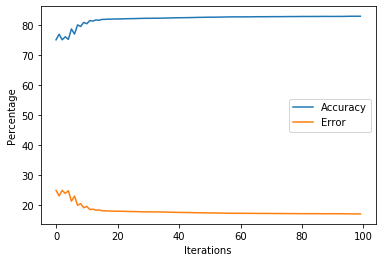

Training set accuracy : 82.96200517207082
Testing set accuracy : 82.96812749003985


In [32]:
theta, cost, acc, error = logistic_regression(x_train, y_train, iters, alpha)
plot_acc_err(iters, acc, error)
train_accuracy = acc[-1]
y_test_pred = predict(x_test, theta)
test_accuracy = accuracy(y_test, y_test_pred)
print('Training set accuracy :', train_accuracy)
print('Testing set accuracy :', test_accuracy)

# Setting regularization parameters for L1 and L2

In [33]:
lambda_l1, lambda_l2 = 10, 10

# Logistic Regression with L1 regularization on Income dataset

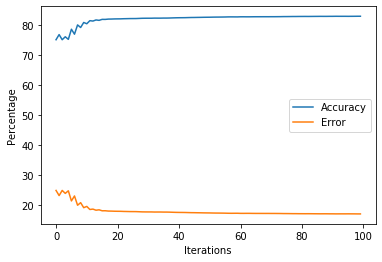

Training set accuracy : 82.93216630196937
Testing set accuracy : 83.00796812749005


In [34]:
theta, cost, acc, error = logistic_regression_with_L1(x_train, y_train, iters, alpha, lambda_l1)
plot_acc_err(iters, acc, error)
train_accuracy = acc[-1]
y_test_pred = predict(x_test, theta)
test_accuracy = accuracy(y_test, y_test_pred)
print('Training set accuracy :', train_accuracy)
print('Testing set accuracy :', test_accuracy)

# Logistic Regression with L2 regularization on Income dataset

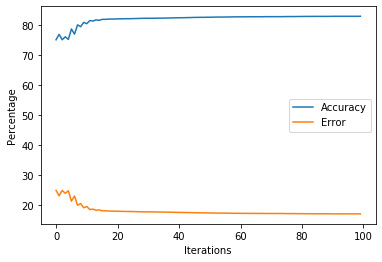

Training set accuracy : 82.95205888203701
Testing set accuracy : 82.97476759628154


In [35]:
theta, cost, acc, error = logistic_regression_with_L2(x_train, y_train, iters, alpha, lambda_l2)
plot_acc_err(iters, acc, error)
train_accuracy = acc[-1]
y_test_pred = predict(x_test, theta)
test_accuracy = accuracy(y_test, y_test_pred)
print('Training set accuracy :', train_accuracy)
print('Testing set accuracy :', test_accuracy)

# Loading MNIST dataset and Preprocessing

In [36]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train.shape = (x_train.shape[0], x_train[0].size)
x_test.shape = (x_test.shape[0], x_test[0].size)
x_train = preprocess(x_train, normalizeMnist)
x_test = preprocess(x_test, normalizeMnist)

# Logistic Regression with L1 regularization on MNIST dataset

In [37]:
theta = logistic_regression_multi(x_train, y_train, x_test, y_test, 'l1')

y_train_pred = predict_multi(x_train, theta)
y_test_pred = predict_multi(x_test, theta)

print("Overall accuracy for training set:", accuracy(y_train, y_train_pred))
print("Overall accuracy for testing set:", accuracy(y_test, y_test_pred))

Class 0
Accuracy for training set: 99.24166666666666
Accuracy for testing set: 99.27
Class 1
Accuracy for training set: 99.20666666666666
Accuracy for testing set: 99.37
Class 2
Accuracy for training set: 97.97666666666667
Accuracy for testing set: 98.18
Class 3
Accuracy for training set: 97.55
Accuracy for testing set: 97.76
Class 4
Accuracy for training set: 98.36666666666667
Accuracy for testing set: 98.22999999999999
Class 5
Accuracy for training set: 97.42666666666666
Accuracy for testing set: 97.58
Class 6
Accuracy for training set: 98.77666666666667
Accuracy for testing set: 98.66
Class 7
Accuracy for training set: 98.50999999999999
Accuracy for testing set: 98.48
Class 8
Accuracy for training set: 96.025
Accuracy for testing set: 96.09
Class 9
Accuracy for training set: 96.50666666666666
Accuracy for testing set: 96.61999999999999
Overall accuracy for training set: 89.565
Overall accuracy for testing set: 89.73


> **The model is slightly underfitted(because of only three iterations, due to size of data) but with more iterations, the model will improve.**

# Logistic Regression with L2 regularization on MNIST dataset

Class 0
Accuracy for training set: 99.23333333333333
Accuracy for testing set: 99.19
Class 1
Accuracy for training set: 99.18666666666667
Accuracy for testing set: 99.41
Class 2
Accuracy for training set: 97.97666666666667
Accuracy for testing set: 98.17
Class 3
Accuracy for training set: 97.58
Accuracy for testing set: 97.81
Class 4
Accuracy for training set: 98.34166666666667
Accuracy for testing set: 98.31
Class 5
Accuracy for training set: 97.39166666666667
Accuracy for testing set: 97.6
Class 6
Accuracy for training set: 98.78166666666667
Accuracy for testing set: 98.71
Class 7
Accuracy for training set: 98.55833333333334
Accuracy for testing set: 98.47
Class 8
Accuracy for training set: 95.99833333333333
Accuracy for testing set: 95.98
Class 9
Accuracy for training set: 96.44166666666666
Accuracy for testing set: 96.61


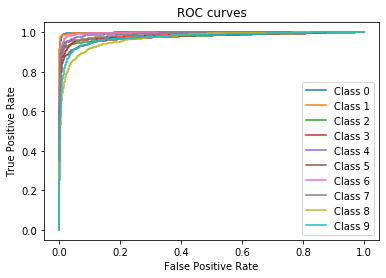

Overall accuracy for training set: 89.69500000000001
Overall accuracy for testing set: 89.88000000000001


In [38]:
theta = logistic_regression_multi(x_train, y_train, x_test, y_test, 'l2')

y_train_pred = predict_multi(x_train, theta)
y_test_pred = predict_multi(x_test, theta)

print("Overall accuracy for training set:", accuracy(y_train, y_train_pred))
print("Overall accuracy for testing set:", accuracy(y_test, y_test_pred))

> **The model is slightly underfitted(because of only three iterations, due to size of data) but with more iterations, the model will improve.**